# Assignment 1

# Density estimation using Real NVP

Normalizing flows are the class of probabilistic models that provides flexible parametrical probabilistic models, where the probability density function can be computed exactly. In the assignment, we will consider a real-valued non-volume preserving normalizing flows (Real NVP) -- a special case of normalizing flow.

#### Problem setting

Our goal is to training a generative network $g_\theta:  Z \rightarrow X, g = f^{-1}$ that maps latent variable $z \sim p(z)$ to a sample $x \sim p(x)$. Where $p(z)$ is a prior distibiution and $p(x)$ is a data distibution. An illustrative example is provided below. 

<img src="2d-example.png" width=600px>


#### Change of variable formula

Given an observed data variable $x \in X$,
a simple prior probability distribution $p_{Z}$ on a latent variable $z \in Z$,
and a bijection $f: X \rightarrow Z$ (with $g = f^{-1}$),
the change of variable formula defines a model distribution on $X$ by
\begin{align}
p_{X}(x) &= p_{Z}\big(f(x)\big) \left|\det\left(\cfrac{\partial f(x)}{\partial x^T} \right)\right|
\label{eq:change-variables}\\
\log\left(p_{X}(x)\right) &= \log\Big(p_{Z}\big(f(x)\big)\Big) + \log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
,
\end{align}
where $\frac{\partial f(x)}{\partial x^T}$ is the Jacobian of $f$ at $x$.

Exact samples from the resulting distribution can be generated by using the inverse transform sampling rule. A sample $z \sim p_{Z}$ is drawn in the latent space, and its inverse image $x = f^{-1}(z) = g(z)$ generates a sample in the original space. Computing the density on a point $x$ is accomplished by computing the density of its image $f(x)$ and multiplying by the associated Jacobian determinant $\det\left(\frac{\partial f(x)}{\partial x^T}\right)$.

#### Real NVP

Real NVP presents a class of functions where $\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)$ can be computed efficiently (see, 3.3 Properties, https://arxiv.org/abs/1605.08803). Every layer of Real NVP is a coupling layer followed by permutation layer. Combination of coupling and permutation layers can be implemented as a masked version of the coupling layer:
\begin{align}
y = b \odot x + (1 - b) \odot \Big(x \odot \exp\big(s(b \odot x)\big) + t(b \odot x)\Big),
\end{align}

where $s$ and $t$ stand for scale and translation, and are functions from $R^{D} \mapsto R^{D}$, and $\odot$ is the Hadamard product or element-wise product, $b$ is a binary mask. For more details on the model see the paper Density estimation using Real NVP https://arxiv.org/abs/1605.08803.

# In this assignment:
1. Implementation of Real NVP
2. Training Real NVP on 2d circles or moons dataset
3. Visualization of the generative model
4. Optional Research Assignment

Additional information:
- You will need the following python packages: pytorch, numpy, sklearn, pylab (matplotlib).
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 2 2018".
- A submission policy will be released later.

# Implementation of Real NVP

In [2]:
import torch
from torch import nn
from torch.nn.parameter import Parameter

In [194]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        x = z
        for layer_ind in reversed(range(len(self.mask))):
            masked_argument = x * self.mask[layer_ind]
            x = (
                masked_argument + (1 - self.mask[layer_ind]) *
                (x - self.t[layer_ind](masked_argument)) * torch.exp(-self.s[layer_ind](masked_argument))
            )
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        z = x
        log_det_J = torch.zeros(list(x.size())[0])
        for layer_ind in range(len(self.mask)):
            masked_argument = z * self.mask[layer_ind]
            curr_s_result = self.s[layer_ind](masked_argument)
            log_det_J += torch.sum(curr_s_result * (1 - self.mask[layer_ind]), dim=1)
            
            z = (
                masked_argument + (1 - self.mask[layer_ind]) * 
                (z * torch.exp(curr_s_result) + self.t[layer_ind](masked_argument))
            )
            
        return z, log_det_J
    
    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        logp = self.prior.log_prob(z) + log_det_J
        return logp
        
    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)a
        z = self.prior.sample((batchSize,))
        x = self.g(z)
        return x

In [195]:
dim_X = 2

In [196]:
def add_dense(model, prev_units, curr_units, ind):
    model.add_module('relu_' + str(ind), nn.ReLU())
    # model.add_module('batch_norm_' + str(ind), nn.BatchNorm1d(prev_units))
    # model.add_module('dropout_' + str(ind), nn.Dropout(p=0.2))
    model.add_module('linear_' + str(ind), nn.Linear(prev_units, curr_units))


def build_simple_model():
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(dim_X, 100))
    units = [100, 100, 100, 100, dim_X]
    for i in range(len(units) - 1):
        add_dense(model, units[i], units[i + 1], i + 1)
    return model

In [197]:
nets = build_simple_model
nett = build_simple_model

assert list(nets()(torch.zeros((2, dim_X))).size()) == [2, dim_X]

In [206]:
import numpy as np
number_of_coupling_layers = 50
# torch.Tensor of size #number_of_coupling_layers x #dim(X)
masks = torch.from_numpy(np.tile([[1, 0], [0, 1]], (int(number_of_coupling_layers / 2), 1))).type(torch.FloatTensor)
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.
assert ((masks.numpy() == 0) + (masks.numpy() == 1)).all()
assert torch.all(torch.sum(masks, dim=1) == torch.ones(number_of_coupling_layers))

In [207]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Check that prior has log_prob and sample methods
print(prior.log_prob(torch.from_numpy(np.array([0, 1])).type(torch.FloatTensor)))
print(prior.sample((2,)))

tensor(-2.3379)
tensor([[ 0.3692, -1.1936],
        [ 0.0600,  1.1192]])


In [210]:
flow = RealNVP(nets, nett, masks, prior)
# Check that a flow is reversible g(f(x)) = x
# With a big chance you have some errors in RealNVP.log_prob, think hard on it.
x = torch.from_numpy(np.array([[0.0, 1.0], [0.0, 0.1]])).type(torch.FloatTensor)
print(flow.g(flow.f(x)[0]))
assert torch.sum((flow.g(flow.f(x)[0]) - x) ** 2) < 1e-6

tensor([[-7.1236e-09,  1.0000e+00],
        [ 1.4106e-08,  1.0000e-01]], grad_fn=<AddBackward0>)


In [211]:
from sklearn import datasets

# list of all trainable parameters in a flow
trainable_parametrs = list(flow.t.parameters()) + list(flow.s.parameters())
# choose an optimizer, use module torch.optim
optimizer = torch.optim.Adam(trainable_parametrs, lr=0.00005)

for t in range(15001):    
    noisy_circles = datasets.make_circles(n_samples=100, factor=.5, noise=.05)
    # compute the maximum-likelihood loss
    loss = -torch.mean(flow.log_prob(torch.from_numpy(noisy_circles[0]).type(torch.FloatTensor)))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
# Check that the loss decreases
# Is the visualization below good?

iter 0: loss = 2.113
iter 500: loss = 1.275
iter 1000: loss = 1.139
iter 1500: loss = 1.140
iter 2000: loss = 0.892
iter 2500: loss = 0.884
iter 3000: loss = 0.860
iter 3500: loss = 0.840
iter 4000: loss = 0.857
iter 4500: loss = 0.934
iter 5000: loss = 0.752
iter 5500: loss = 0.737
iter 6000: loss = 0.909
iter 6500: loss = 0.704
iter 7000: loss = 0.597
iter 7500: loss = 0.570
iter 8000: loss = 0.791
iter 8500: loss = 0.720
iter 9000: loss = 0.758
iter 9500: loss = 0.756
iter 10000: loss = 0.758
iter 10500: loss = 0.796
iter 11000: loss = 0.699
iter 11500: loss = 0.766
iter 12000: loss = 0.581
iter 12500: loss = 0.644
iter 13000: loss = 0.677
iter 13500: loss = 0.647
iter 14000: loss = 0.709
iter 14500: loss = 0.703
iter 15000: loss = 0.496


# Visualization

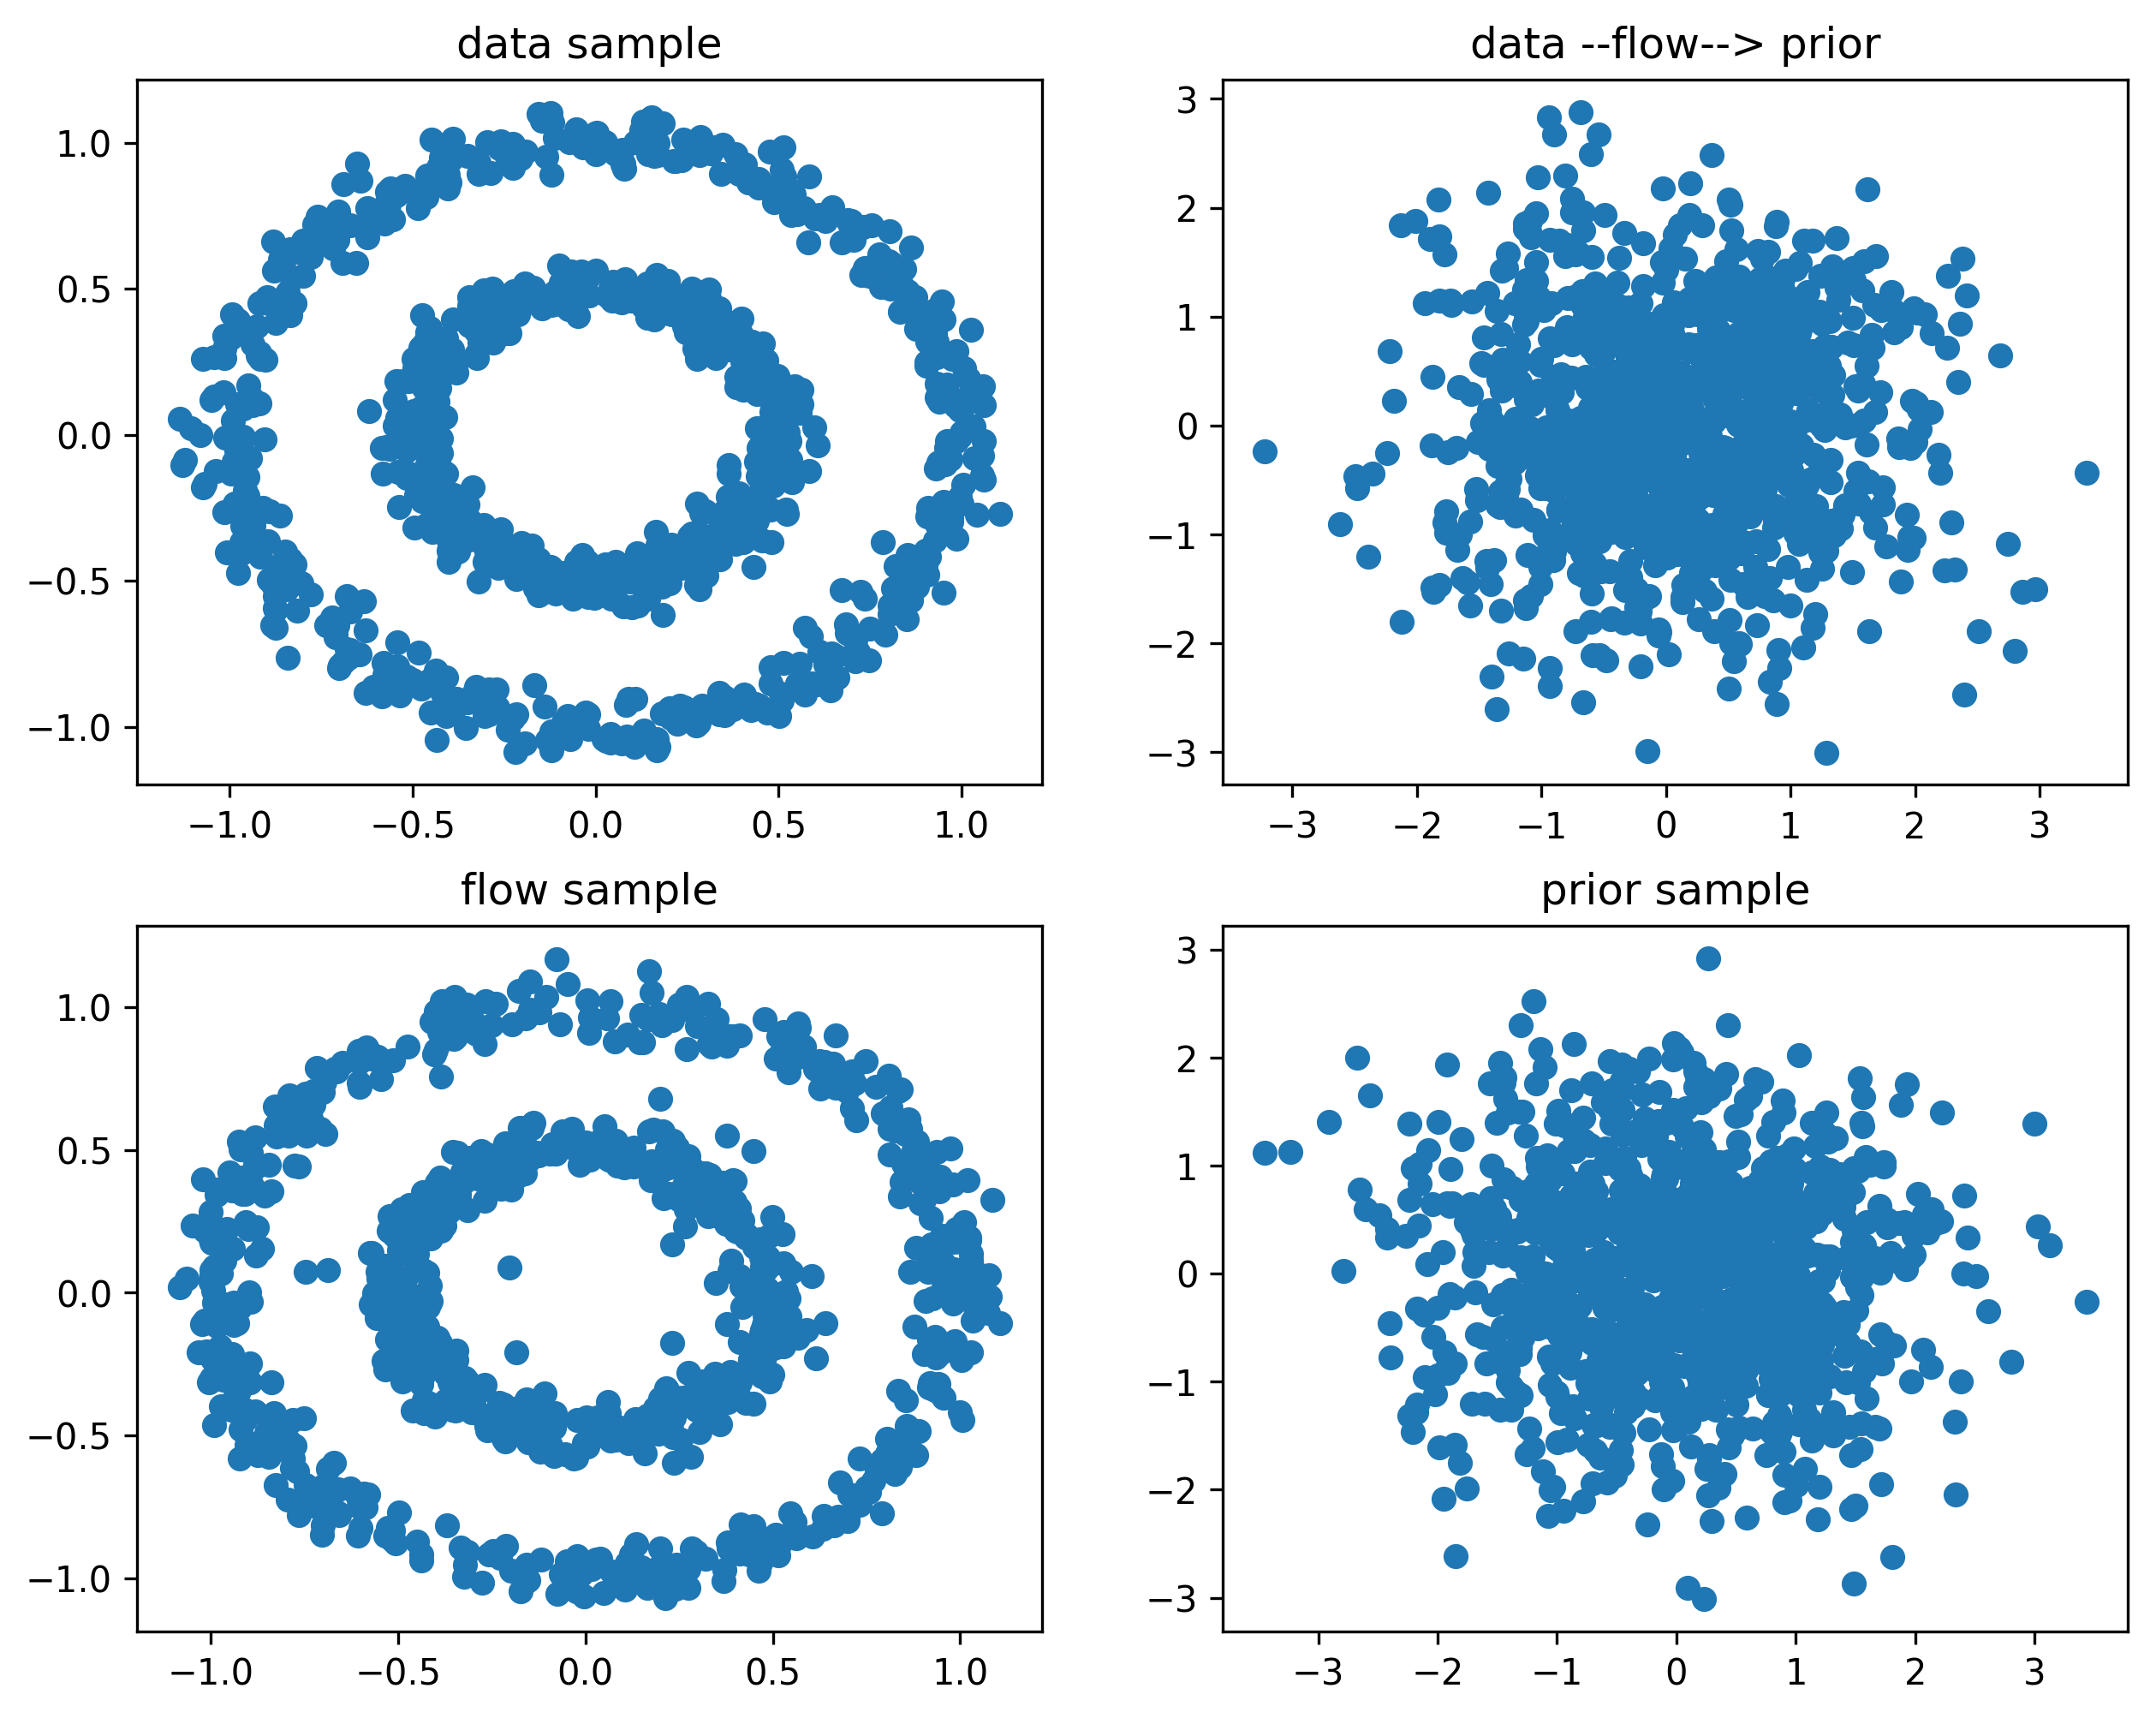

In [213]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)[0]
prior_from_data = flow.f(torch.from_numpy(noisy_circles).type(torch.FloatTensor))[0].detach().numpy()
flow_sample = flow.sample(n_samples).detach().numpy()
prior_sample = flow.prior.sample((n_samples,)).numpy()
fig, axes = plt.subplots(2, 2)
axes[0, 0].set_title('data sample')
axes[0, 0].scatter(noisy_circles[:, 0], noisy_circles[:, 1])
axes[0, 1].set_title('data --flow--> prior')
axes[0, 1].scatter(prior_from_data[:, 0], prior_from_data[:, 1])
axes[1, 0].set_title('flow sample')
axes[1, 0].scatter(flow_sample[:, 0], flow_sample[:, 1])
axes[1, 1].set_title('prior sample')
axes[1, 1].scatter(prior_sample[:, 0], prior_sample[:, 1])

In [214]:
torch.save(flow, 'flow.torch')

/usr/local/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type RealNVP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Draw several plots: 
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

The goal is to obtain figure similar to https://arxiv.org/abs/1605.08803

## Providde answerrs for the folowing questions:

1. What architecture worked better in your experiments?


**Your answer with justification**


2. Did you find what is important for stable training (initializations, nonlinearities, ...)?


**Your answer with justification**


3. How convergence speed (in iterations) depends on the complexity of architecture?


**Your answer with justification**


# Optional Research Assignments:

This assignment is optional. It will give you up to 2 additional points for one of the assignment.   
#### 1. VAE: 
Use normalizing flow to get more expressive $q(z\,|\,x)$,  https://arxiv.org/abs/1505.05770. TL;dr; use decoder to predict $z_0 \sim q_0(z_0|x)$, than use NF to obtain $z_k = f_k \circ \dots \circ f_1(z)$ sample from a more flexible distribution. Compare it with a conventional normal distribution, what is working better? Compare it with conventional VAE  that uses the same number of parameters as VAE with NF.

#### 2. Expressiveness: 
- Train the flow on an another 2d-dataset e.g., a mixture of 6 Gaussians (see figure 10, https://openreview.net/pdf?id=Hkg313AcFX). Is it possible to fit it with a normalizing flow? What is more beneficial increase size of s and t or increase the depth? Provide a justification for the answer e.g. plots.
- Use the flow to sample images from a more complex dataset, e.g. downsampled MNIST (8x8 should be fine). Do your findings remains the same? Also, provide plots.
